# Modèle électrique équivalent de bâtiment

Avec la classe RC_model de la bibliothèque de développement, on peut fitter un modèle électrique de bâtiments de type R3C2. Cette classe est disponible en important le module `src.modelrc` de la bibliothèque.
On va aussi importer les outils de manipulation des flux, disponibles dans le module `src.tools` pour pouvoir faire quelques vérifications préliminaires sur les flux, mais on n'en pas véritablement besoin pour mener l'optimization.


In [1]:
from src.modelrc import *
from src.tools import PHPFina,getMetas
import numpy as np



## le circuit cellules de la chaufferie gaz du Cerema Clermont-Ferrand

On va s'intéresser au circuit cellules du bâtiment laboratoire du Cerema Clermont-Ferrand, pour lesquels les données suivantes sont disponibles :
- température extérieure en °C : flux 18
- température intérieure en un point assez éloigné du circuit, pour se placer dans la situation la plus défavorable en °C : flux 56
- puissance de chauffage consommée en W : flux 66
- radiation solaire globable en W/m2 : flux 21

On commence par initialiser la précision choisie, c'est-à-dire le nombre de points à utiliser pour décrire une heure, içi 2, soit un point toutes les demi-heures, ainsi que le fichier des paramètres d'après les numéros de flux.

In [2]:
# number of points in an hour
nbptinh=2
step=3600//nbptinh

dir="labo/phpfina"

house="labo cellules"
params=[ {"id":18,"name":"outdoor temp","color":"blue","action":"smp"},
         {"id":56,"name": "cells indoor temp","color":"purple","action":"smp"},
         {"id":66,"name":"cells hvac power (W)","color":"red","action":"smp"},
         {"id":21,"name":"solar power (W)","color":"yellow","action":"smp"}]

print("les métadonnées des flux choisis sont les suivantes :")
getMetas(18,dir=dir)
getMetas(56,dir=dir)
getMetas(66,dir=dir)
getMetas(21,dir=dir)


les métadonnées des flux choisis sont les suivantes :
(10, 1575981140)
(300, 1577785800)
(10, 1575981390)
(10, 1575981210)


Dans toutes les listes affichées, la première valeur représente l'intervalle d'enregistrement en secondes, alors que la seconde représente l'unix time stamp, également en secondes, à partir duquel la première donnée du flux a été enregistrée. 

Ce sont des flux à intervalle fixe. Chaque fois que l'on a des données manquantes, on a dans le fichier une indication NAN pour not a number.....

On va donc travailler avec des flux utilisant des intervalles d'enregistrements différents :
- les température extérieure, puissance de chauffage et apports solaires ont été enregistrés toutes les 10 secondes
- la température extérieure a été enregistrée toutes les 5 minutes (300 secondes)

On constate que parmi les 4 flux, celui qui commence en dernier est le flux de température intérieure. C'est à cette date égale à 1577785800 que l'on décide de démarrer le sampling.
On définit pour celà une variable start.

On fixe enfin un nombre de jours à couvrir, pour délimiter la période sur laquelle on va mener notre optimisation. Il s'agit de la variable tDays içi égale à 30

In [3]:
tDays=30


from datetime import datetime
from dateutil import tz
start=1577785800
utc=tz.gettz('UTC')
CET=tz.gettz('Europe/Paris')
_time=datetime.fromtimestamp(start,CET)
_utc_start=datetime.fromtimestamp(start,utc)
print("le sampling synchrone commencera à la date :")
print("à l'heure de Paris {}".format(_time.strftime('%Y-%m-%d %H:%M:%S')))
print("à l'heure universelle {}".format(_utc_start.strftime('%Y-%m-%d %H:%M:%S')))


le sampling synchrone commencera à la date :
à l'heure de Paris 2019-12-31 10:50:00
à l'heure universelle 2019-12-31 09:50:00


Vérifions désormais les positions où le sampling commencera pour chaque flux

In [4]:
# just to verify the sampling positions....
for i in range(len(params)):
    id=params[i]["id"]
    feed=PHPFina(id,step,dir)
    feed.getMetas()
    feed.setStart(start)
    nbsteps=tDays*24*nbptinh
    feed.getDatas(nbsteps)
    print("la lecture du flux feed {} commencera à la position {}".format(id,feed._SamplingPos))

la lecture du flux feed 18 commencera à la position 180466
la lecture du flux feed 56 commencera à la position 0
la lecture du flux feed 66 commencera à la position 180441
la lecture du flux feed 21 commencera à la position 180459


Désormais que l'on connait un peu mieux les données avec lesquelles on va travailler, construisons l'objet à optimiser. Nous allons optimiser un modèle R3C2 qui comporte 5 paramètres à optimiser :
- $C_{res}$ : capacité rapide liée à l'air extérieur
- $C_s$ : capacité lente liée à l'inertie du bâtiment
- $R_i$ : résistance thermique des murs côté intérieur
- $R_0$ : résistance thermique des murs côté extérieur
- $R_f$ : résistance de fuite, liée à la perméabilité

Les capacités s'expriment en J/K alors que les résistances sont en K/W


Introduisons le vecteur $T_p$ des inconnues de température propres à notre problème : 
- température intérieure 
- température de surface.

\begin{equation*}
T_p(t) = \begin{vmatrix}
T_i(t) \\
T_s(t) \\
\end{vmatrix}
\end{equation*}

Nous disposons d'une vérité terrain seulement pour la température intérieure. En matière de température de surface, nous n'avons aucune donnée en notre possesion. Il s'agit donc d'une inconnue non observée.

Pour évaluer la valeur initiale de $T_p$, nous utiliserons la fonction ci dessous :

In [5]:
"""
how to make a guess for the first initial envelope temperature ?
i is the set number in the RC_model
"""
def Tp0(i):
    x=labocells._truth[i][0]
    # external temperature
    y=labocells._inputs[i][0,0]
    return np.array([x,(x+2*y)/3])

Pour mémoire, le problème à résoudre revient à résoudre l'équation différentielle suivante :

\begin{equation*}
\frac{dT_p(t)}{dt} = A(p) T_p(t) + B(p) U(t)
\end{equation*}

avec p vecteur des paramètres et U vecteur des sollicitations :

<table>
    <tr>
        <td>
$p=\begin{vmatrix}
c_{res} \\
c_s \\
r_i \\
r_0 \\
r_f
\end{vmatrix}$
        </td><td>
$U=\begin{vmatrix}
T_{ext} \\
Q_{res} \\
Q_{s} \\
\end{vmatrix}$
        </td>
    </tr>
</table>
    


On rappelle expressions des matrices A(p) et B(p) :

<table>
    <tr>
        <td>
$A(p) =\begin{vmatrix}
-\frac{1}{c_{res}} (\frac{1}{r_i}+\frac{1}{r_f}) & \frac{1}{c_{res} r_i} \\
\frac{1}{c_s r_i} &  - \frac{1}{c_s} (\frac{1}{r_i}+\frac{1}{r_0}) \\
\end{vmatrix}$
        </td><td>
$B(p) =\begin{vmatrix}
\frac{1}{c_{res} r_f} & \frac{1}{c_{res}} & 0 \\
\frac{1}{c_s r_0} & 0 & \frac{1}{c_s} \\
\end{vmatrix}$
        </td>
    </tr>
</table>

Cres représente l'air intérieur qu'il faut chauffer : lorsqu'on le prend trop petit, la température modélisée sera très bruitée. Elle réagira très brusquement aux variations de puissance par exemple. 

De son côté, une valeur de Cs trop importante contribura à "figer" la température de surface : l'enveloppe devient comme imperméable.

La fonction coût que l'on va optimiser (içi la moitié de la somme des écarts entre le carré de la température intérieure modélisée et le carré de la température intérieure mesurée) possède des minimums locaux et il se peut tout à fait que l'algorithme de gradient soit coincé dans une de ces vallées fort locales.....Il est donc important de cibler les ordres de grandeurs initiaux mais celà n'élimine pas le risque d'optimiser vers quelque chose de peu réaliste, comme par exemple avec un Cs trop important.  

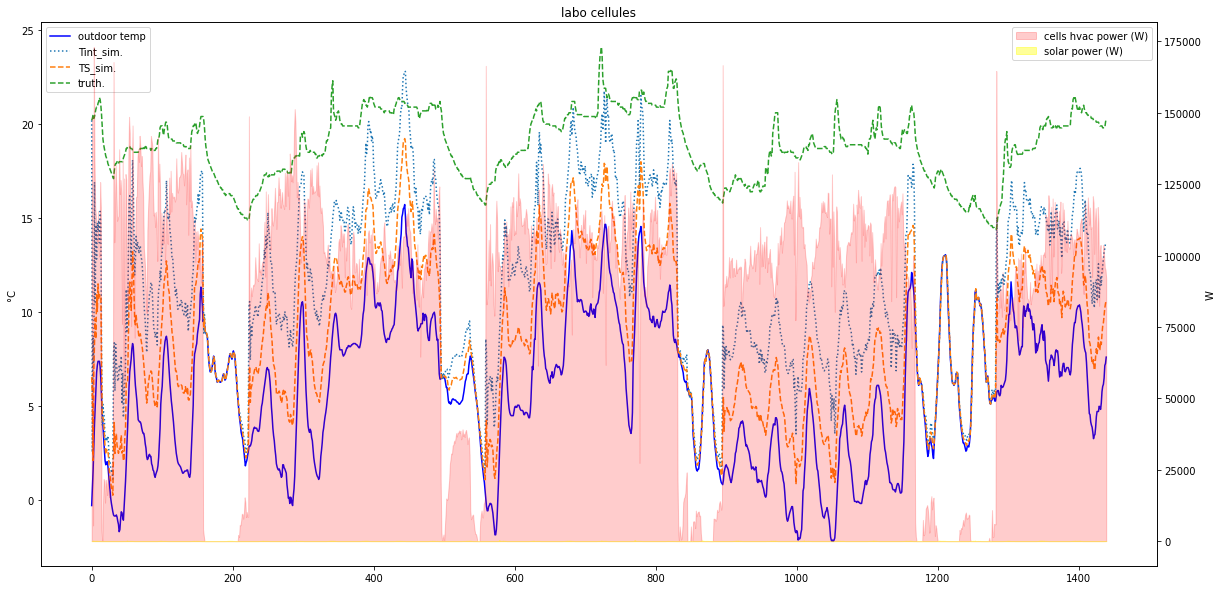

In [6]:
# initial guess
# scaling
p0=np.array([1e+6,1e+6,1e-4,1e-4,1e-4])
# weights
w0=np.array([4.0,4.0,1.0,1.0,1.0])
labocells=RC_model(house,params,nbptinh,p0,w0,FINASun=True)
labocells.buildSet(start,tDays,[0,2,3],1,dir)

import matplotlib.pylab as plt
fig = plt.figure(figsize=(20, 10))
labocells.viewSet(0,Tp0(0),full=False)

La courbe en pointillé vert est la vérité terrain en matière de température intérieure. La courbe en pointillé bleu représente la température intérieure et la courbe en pointillé orange la température de surface ou d'enveloppe telles que simulées par le schéma de discrétisation de Krank-Nicholson.

On ne va pas donner les détails de ce schéma ni ceux du calcul du gradient associé à ce schéma via la méthode adjointe. Les démonstrations mathématiques sont disponibles dans le répertoire doc de la bibliothèque (ne pas confondre avec la documentation de la bibliothèque qui est purement informatique, générée automatiquement depuis le code et sans éléments mathématiques)

La radiation solaire globale dont on dispose est issue d'un capteur de station météo. C'est une valeur en W/m2. Il faudrait la multiplier par la surface d'exposition du bâtiment, ce qui n'est pas facile, vu que le bâtiment comporte 3 circuits de chauffage et qu'on ne connait pas les surfaces d'exposition correspondantes. On va donc dans un premier temps se contenter de la multiplier par 50....


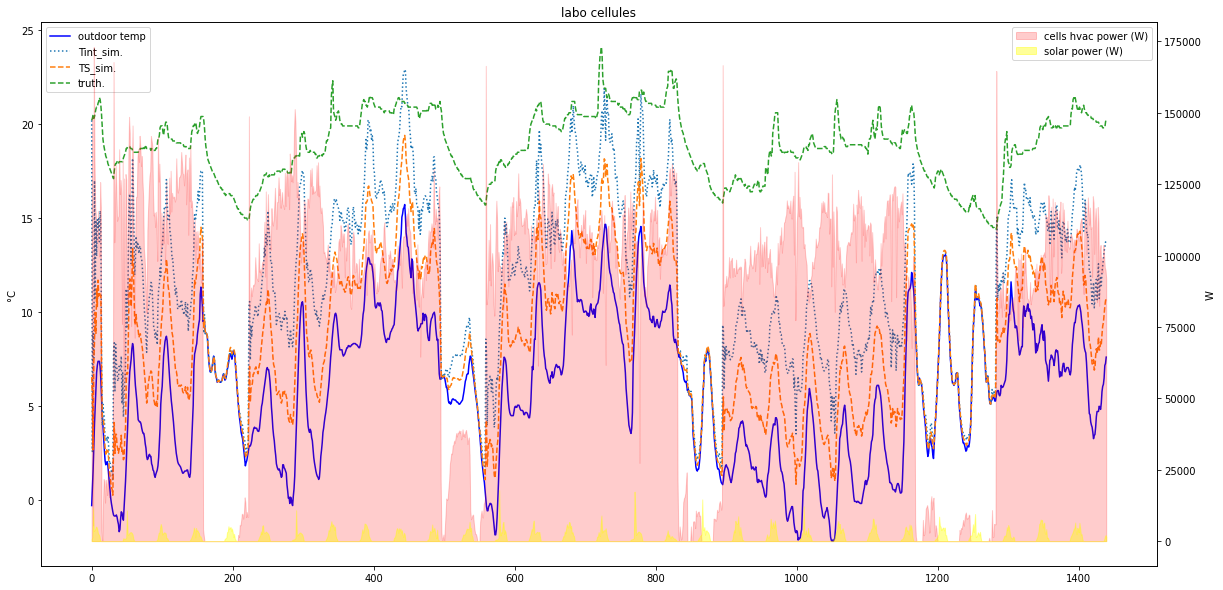

In [7]:
#increasing sun
K=50
labocells._inputs[0][:,2]=K*labocells._inputs[0][:,2]
fig = plt.figure(figsize=(20, 10))
labocells.viewSet(0,Tp0(0),full=False)

On peut désormais lancer l'optimisation

/home/alexandrecuer/BIOS/src/modelrc/modelrc.py:321: RuntimeWarning: overflow encountered in square
  return 0.5*np.sum(np.square(x-truth))/x.shape[0]
/home/alexandrecuer/BIOS/src/modelrc/modelrc.py:363: RuntimeWarning: overflow encountered in multiply
  S[j-1]=S[j].T.dot(AS_C)+np.array([x[j,0]-truth[j],0]).T.dot(AS_B)*2/len(x)
/home/alexandrecuer/BIOS/src/modelrc/modelrc.py:368: RuntimeWarning: overflow encountered in add
  df[j]+=S[i].dot(dA[j].dot(x[i+1]+x[i])+dB[j].dot(inputs[i+1,:]+inputs[i,:]))/2
/home/alexandrecuer/BIOS/src/modelrc/modelrc.py:321: RuntimeWarning: overflow encountered in square
  return 0.5*np.sum(np.square(x-truth))/x.shape[0]
/home/alexandrecuer/BIOS/src/modelrc/modelrc.py:321: RuntimeWarning: overflow encountered in square
  return 0.5*np.sum(np.square(x-truth))/x.shape[0]
/home/alexandrecuer/BIOS/src/modelrc/modelrc.py:321: RuntimeWarning: overflow encountered in square
  return 0.5*np.sum(np.square(x-truth))/x.shape[0]


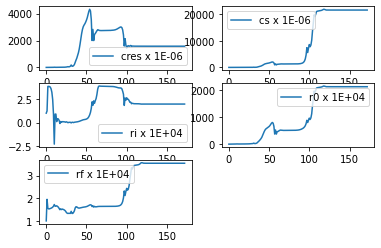

      fun: 0.6527654698848965
 hess_inv: array([[ 1.70115160e+06, -6.20386273e+06,  3.13803190e+02,
        -2.98038362e+05, -9.29565964e+02],
       [-6.20386273e+06,  2.41396249e+09, -6.17121812e+04,
         2.09857621e+08,  2.40961326e+05],
       [ 3.13803190e+02, -6.17121812e+04,  2.89084356e+00,
        -5.33291895e+03, -8.37343516e+00],
       [-2.98038362e+05,  2.09857621e+08, -5.33291895e+03,
         1.82785893e+07,  2.08846741e+04],
       [-9.29565964e+02,  2.40961326e+05, -8.37343516e+00,
         2.08846741e+04,  2.82867129e+01]])
      jac: array([-2.10336789e-10,  4.67291040e-10,  3.07993066e-05, -2.18052146e-08,
        1.51340743e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 188
      nit: 108
     njev: 173
   status: 2
  success: False
        x: array([1.57926600e+03, 2.16272771e+04, 1.96026396e+00, 2.11780771e+03,
       3.54605071e+00])
[1.57926600e+09 2.16272771e+10 1.96026396e-04 2.11780771e-01
 3.54605071e-04]


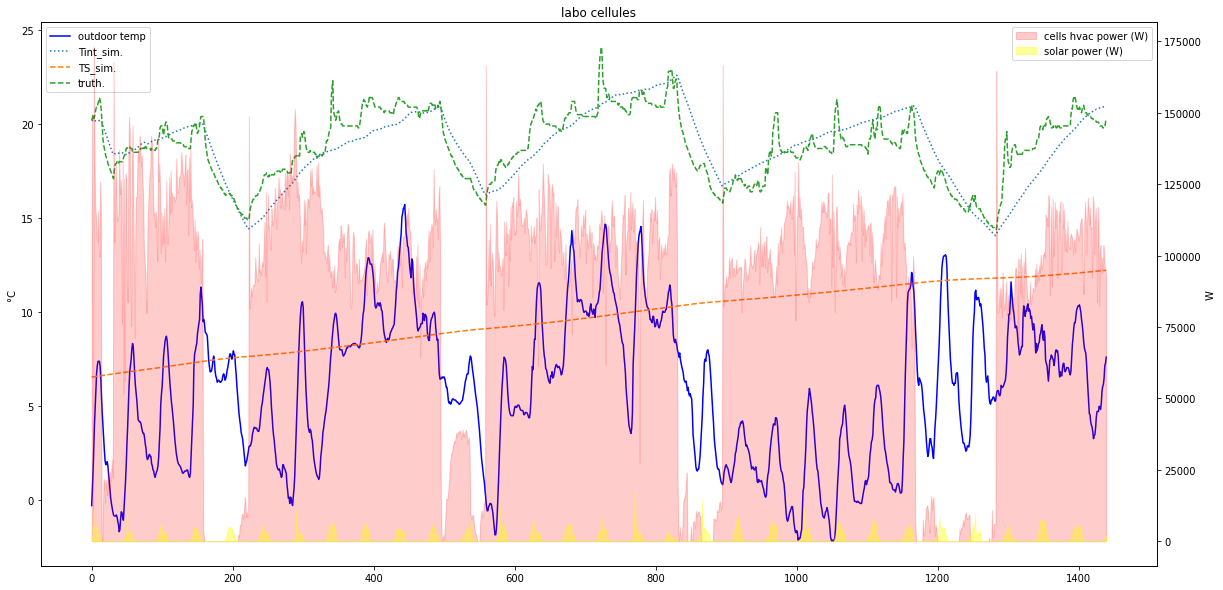

In [8]:
labocells.optimize(0,Tp0(0),verbose=False)
fig = plt.figure(figsize=(20, 10))
labocells.viewSet(0,Tp0(0),full=False)

Voila ce que donne le modèle optimisé sur des données non connues

In [9]:
# adding set 1 to check if things can be correctly predicted...
labocells.buildSet(1579492800,30,[0,2,3],1,dir)
labocells._inputs[1][:,2]=K*labocells._inputs[1][:,2]

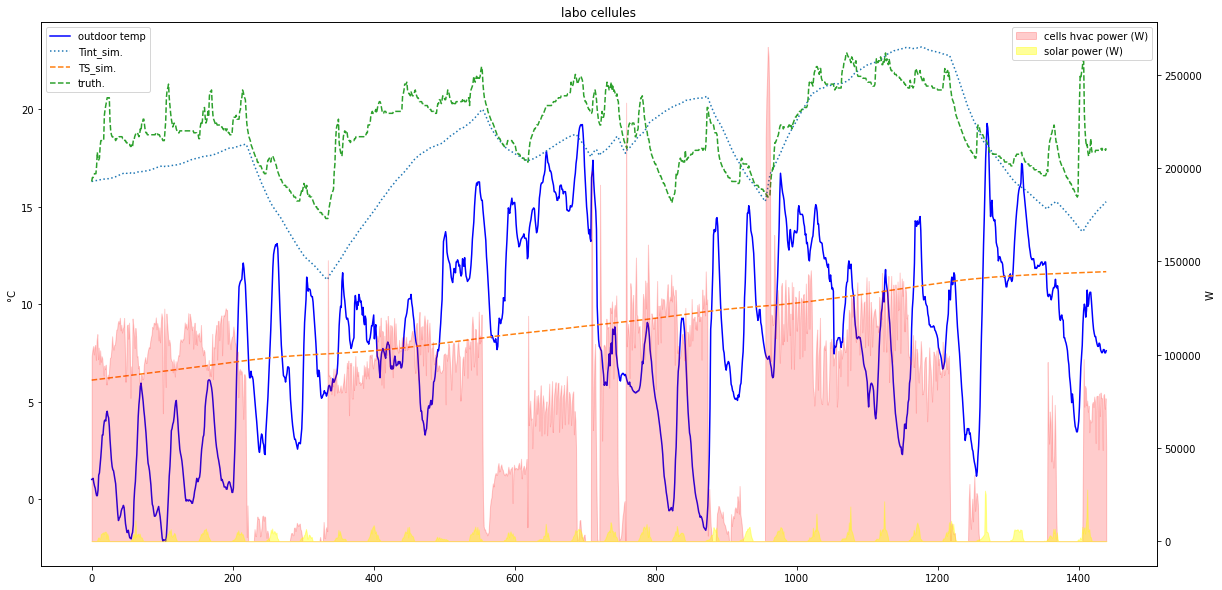

In [10]:
fig = plt.figure(figsize=(20, 10))
labocells.viewSet(1,Tp0(1),full=False)

Par contre dès qu'on ne chauffe plus, on voit que le modèle ne fonctionne plus. En mode climatisation, le modèle n'est plus vraiment valable 

In [11]:
# adding set 2 to check if things can be correctly predicted...
labocells.buildSet(1584252000,20,[0,2,3],1,dir)
labocells._inputs[2][:,2]=K*labocells._inputs[2][:,2]

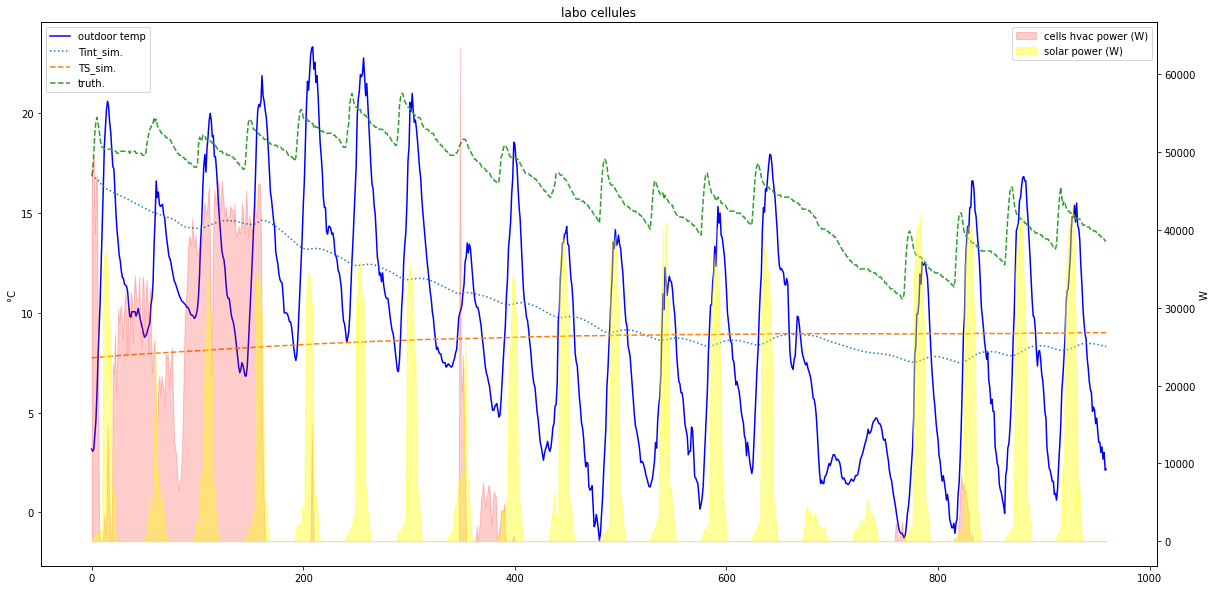

In [12]:
fig = plt.figure(figsize=(20, 10))
labocells.viewSet(2,Tp0(2),full=False)